In [1]:
# KORA_S3S4 Data Analysis - Minimum Model

import math 
import numpy as np
import statistics
import pandas as pd
import scipy.stats
import seaborn as sns
import os
import pandas_profiling as pp
from matplotlib import pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import impute
import pandas_profiling as pp
import nbimporter
import Modeling
from IPython.core.debugger import set_trace
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
import statsmodels.api as sts
%matplotlib inline

## Loading the data and data splitting

In [2]:

KORA_Noise_noMissing = pd.read_csv('C:\\Users\\sahar.behzadi\\Desktop\\Noise2Nako\\Data\\KORA_S3_S4\\KORA_Noise_noMissing_median.csv')

In [3]:
# Inputs

X = KORA_Noise_noMissing.drop(['hyper_p', 'bp_diast', 'bp_syst'], axis = 1)
X_mini = KORA_Noise_noMissing[['sex', 'age', 'bmi', 'smoking', 'lden_org']]
print('Data description \n')
print('Sex: Female = 0, Male = 1 \n Smoking: Current = 1, Ex-smoker = 2, Never smoker =3 \n ')


# Output

Y_hyper = KORA_Noise_noMissing['hyper_p'].astype(int)
Y_SBP = KORA_Noise_noMissing['bp_syst']
Y_DBP = KORA_Noise_noMissing['bp_diast']

Data description 

Sex: Female = 0, Male = 1 
 Smoking: Current = 1, Ex-smoker = 2, Never smoker =3 
 


### Explainable AI - Categories
#### 
<img src='img/XAI_categories.png' style='width:15cm;height:8cm'>  

1. <b> Perturbation-based : </b>
Check what happens to the classifier or the regressor when some chnages happen to the input, e.g. masking the input image and see which features are more important.

- <b> Dis: </b>
slow
assumes locality (may different features are important to the task!)
perturbation may introduce artefacts (the way we manipulate the input could have some impacts on the results)


2. <b> Function-based: </b>
Find the functional perspective of the model and try to intrepret the resuts by the function. Approximate the function by e.g. Taylor decomposition (expansion)

- <b> Dis:</b>
Need to find a good root point where to perform the expansion

- <b> Adv:</b>
Can be applied to any model!

3. <b> Sampling-based:</b>
We approximate the prediction locally. (Gradient * Input)

- <b> Dis:</b>
They are very local! Do not measure global impacts.

- <b> Adv:</b>
Fast, no optimization is required

4. <b> Stuctured-based:</b>
They use the structure of the model to explain the prediction. (Layer-wise Relevance Propagation - LRP). Decompose the function by using the structure and explain the easier function and aggregate them later. 

<b>Intuition :</b> Every layer in a NN, for instance, is a composition of simpler functions (e.g., Relu) 

<img src='img/LRP.png' style='width:15cm;height:8cm'>



In [4]:
import shap
import xgboost
shap.initjs()
model = xgboost.XGBRegressor().fit(X_mini, Y_SBP)

## SHAP Algorithm

SHAP assigns each feature an importance value for a particular prediction. 

#### 1. They introduce the perspective of viewing any explanation of a model’s prediction as a model itself, which they term the explanation model, by defining the class of additive feature attribution methods. 
For complex models, such as ensemble methods or deep networks, we cannot use the original model as its own best explanation because it is not easy to understand. Instead, we must use a simpler explanation model, which we define as any <b> interpretable approximation of the original model </b>. 
A surprising attribute of the class of additive feature attribution methods is the presence of a single unique solution in this class with three desirable properties (described below).

#### 2. Thy then show that game theory results guaranteeing a unique solution apply to the entire class of additive feature attribution methods and propose SHAP values as a unified measure of feature importance that various methods approximate.

#### 3. They propose new SHAP value estimation methods and demonstrate that they are better aligned with human intuition as measured by user studies and more effectually discriminate among model output classes than several existing methods.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


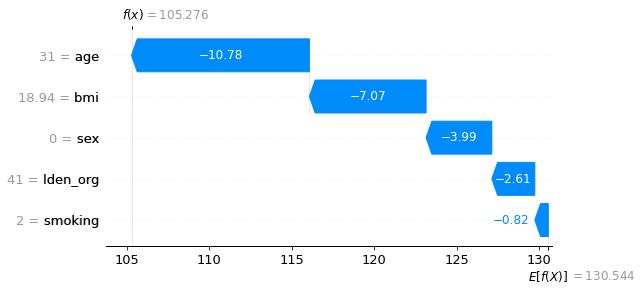

In [5]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_mini)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])
shap.plots.force(shap_values[0])

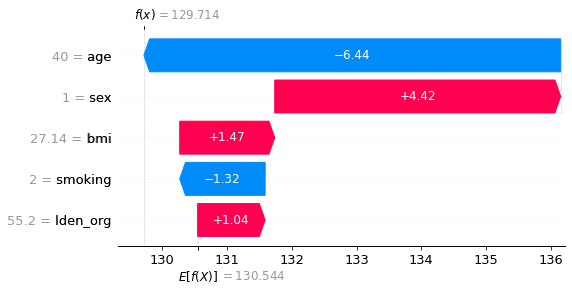

In [6]:
shap.plots.waterfall(shap_values[1])
shap.plots.force(shap_values[1])

In [7]:
print(X_mini.head(5))
print(shap_values[1])
print('The coefficients : ', shap_values[1].values / shap_values[1].data)

   sex   age    bmi  smoking  lden_org
0  0.0  31.0  18.94      2.0      41.0
1  1.0  40.0  27.14      2.0      55.2
2  1.0  59.0  30.34      3.0      55.2
3  0.0  62.0  19.46      1.0      46.8
4  0.0  62.0  31.25      2.0      51.2
.values =
array([ 4.4161687, -6.436804 ,  1.4671109, -1.3191336,  1.0423521],
      dtype=float32)

.base_values =
130.54442

.data =
array([ 1.  , 40.  , 27.14,  2.  , 55.2 ])
The coefficients :  [ 4.41616869 -0.1609201   0.05405714 -0.65956682  0.01888319]


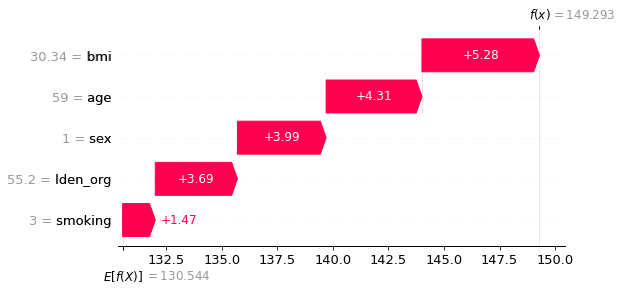

In [8]:
shap.plots.waterfall(shap_values[2])
shap.plots.force(shap_values[2])

In [22]:
observations = X_mini.to_numpy()
shap.initjs() 
shap.force_plot(explainer.expected_value, explainer.shap_values(X_mini),  feature_names=X_mini.columns)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
shap.plots.force is slow for many thousands of rows, try subsampling your data.


In [9]:
# since the algorithm is somehow too slow for the original data we consider a sample and the following plots are for
# a sample data including 100 samples

observations_sample = X_mini.sample(100, random_state=42)
observations = observations_sample.to_numpy()
Y_SBP_sample = Y_SBP[observations_sample.index]
shap.initjs() 
shap.force_plot(explainer.expected_value, explainer.shap_values(observations), features=observations,
                feature_names=X_mini.columns)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Ground Truth: 180.0


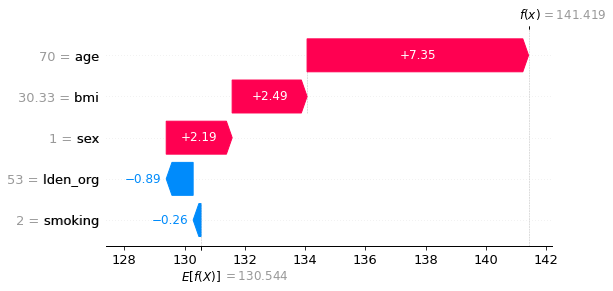

In [10]:
ind = 58
print('Ground Truth:', Y_SBP_sample.to_numpy()[ind])
shap.plots.waterfall(shap_values[ind])
shap.plots.force(shap_values[ind])

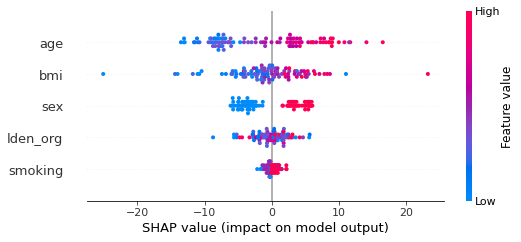

In [11]:
shap.initjs() 

# for the sample
shap.summary_plot(explainer.shap_values(observations), features=observations, feature_names=X_mini.columns)

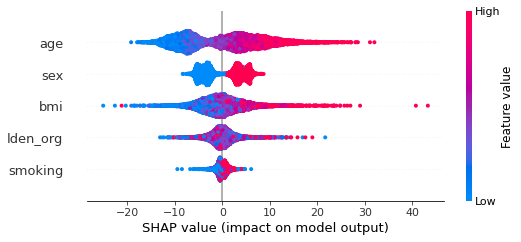

In [12]:
# for the entire dataset
shap.summary_plot(explainer.shap_values(X_mini), features=X_mini, feature_names=X_mini.columns)

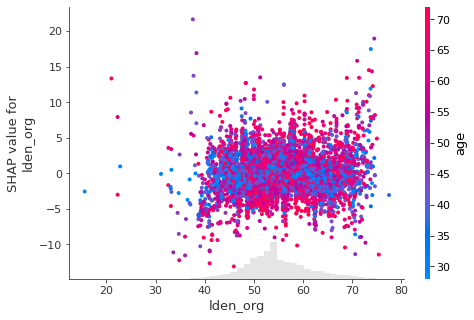

In [49]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"lden_org"], x_jitter=0.5, color = shap_values[:,"age"])

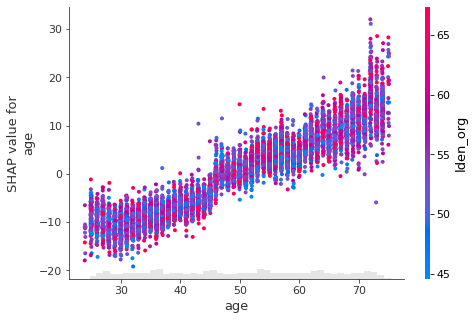

In [14]:
shap.plots.scatter(shap_values[:,"age"], color=shap_values[:,"lden_org"])

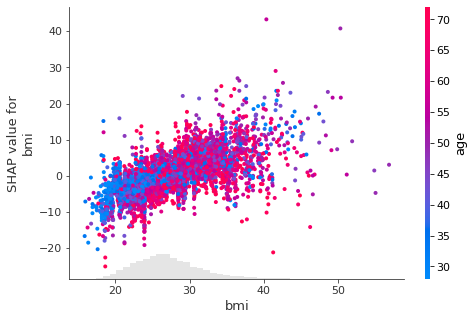

In [15]:
shap.plots.scatter(shap_values[:,"bmi"], color=shap_values)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


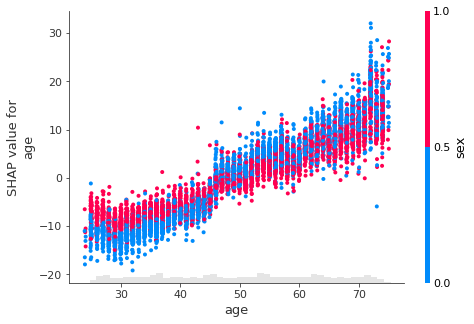

In [16]:
shap.plots.scatter(shap_values[:,"age"], color=shap_values)

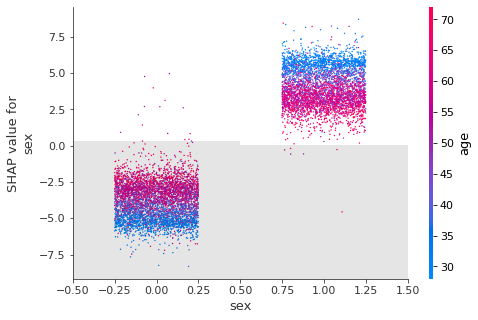

In [17]:
shap.plots.scatter(shap_values[:,"sex"], dot_size=2, x_jitter=0.5, color=shap_values)

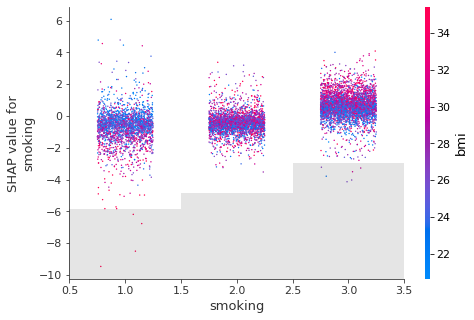

In [18]:
shap.plots.scatter(shap_values[:,"smoking"], dot_size=2, x_jitter=0.5, color=shap_values)

### global measure of feature importance

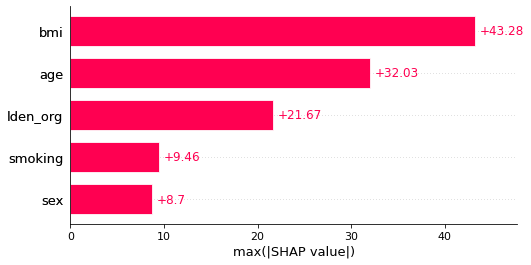

In [19]:
#  max absolute value of shap values for every feature
shap.plots.bar(shap_values.abs.max(0))

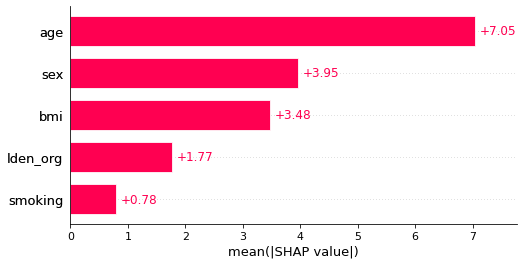

In [20]:
# ploting the mean absolute value for each feature --- 
shap.plots.bar(shap_values)

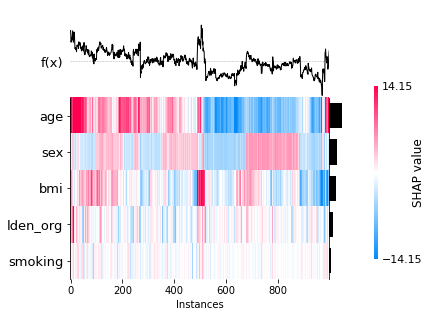

In [21]:
shap.plots.heatmap(shap_values[:1000])

## LIME

LIME stands for Local Interpretable Model-Agnostic Explanations. We can use it with any model we've built in order to explain why it took a specific decision for a given observation. To do so, LIME creates a dataset in the locality of our observation by perturbating the different features. Then it fits a local linear model on this data and uses the weights on each feature to provide an explanation.

Intuitively, an explanation is a local linear approximation of the model's behaviour. While the model may be very complex globally, it is easier to approximate it around the vicinity of a particular instance. While treating the model as a black box, we perturb the instance we want to explain and learn a sparse linear model around it, as an explanation.

The figure below illustrates the intuition for this procedure. The model's decision function is represented by the blue/pink background, and is clearly nonlinear. The bright red cross is the instance being explained (let's call it X). We sample instances around X, and weight them according to their proximity to X (weight here is indicated by size). We then learn a linear model (dashed line) that approximates the model well in the vicinity of X, but not necessarily globally.

<img src='img/lime.png' style='width:10cm;height:6cm'>

In [39]:
import lime
from lime.lime_tabular import LimeTabularExplainer

In [88]:
LR_model = linear_model.LinearRegression().fit(X_mini, Y_SBP)

In [89]:
categorical_features = np.argwhere(np.array([len(set(X_mini.to_numpy()[:,x])) for x in range(X_mini.shape[1])]) <= 10).flatten()

In [90]:
lime_explainer = LimeTabularExplainer(X_mini.to_numpy(), feature_names=X_mini.columns, class_names=['Y_SBP'],
                                      categorical_features=categorical_features, verbose=True, mode='regression')

In [100]:
i = 1
print('SBP_ground truth: ', Y_SBP[i])
exp_LR = lime_explainer.explain_instance(X_mini.loc[i].to_numpy(), LR_model.predict, num_features=5)
print(exp_LR)
exp_LR.show_in_notebook(show_table=True)

exp_XGBoost = lime_explainer.explain_instance(X_mini.loc[i].to_numpy(), model.predict, num_features=5)
print(exp_XGBoost)
exp_XGBoost.show_in_notebook(show_table=False)


SBP_ground truth:  143.0
Intercept 127.20242264209043
Prediction_local [132.82250487]
Right: 129.60150739400416


Intercept 127.36371026867334
Prediction_local [131.63113677]
Right: 129.7141


In [92]:
LR_model.coef_

array([8.11123088, 0.51808113, 0.7400769 , 0.84657665, 0.03973358])